In [2]:
"""
STATE: PA
POLICY: Decriminalizing marijuana
VERSION: V2
DATA SOURCE: PA Commission on Sentencing
DATA QUALITY: good
HIGHEST PRIORITY MISSING DATA: N/A
REFERENCE_DATE: January 2020
TIME_STEP: Month
ADDITIONAL NOTES: Initial policy scoping doc https://docs.google.com/document/d/1mj6Fmm3aCmx08PqhNShV6Rb8MCRuHQ2D56BmxeJKxKg/edit?usp=sharing
"""

import logging
import pandas as pd
import numpy as np
import pdb
import matplotlib as plt
from IPython.display import display
import itertools


%run /Users/jazz/Recidiviz/recidiviz-research/utils/research_utils.py

pd.options.display.max_colwidth = None
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("max_seq_items", None)
pd.set_option("display.width", None)

In [3]:
import sys

sys.path.insert(1, "/Users/jazz/Recidiviz/pulse-data")

In [4]:
from recidiviz.calculator.modeling.population_projection.super_simulation.time_converter import (
    TimeConverter,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import (
    upload_spark_model_inputs,
)
from recidiviz.calculator.modeling.population_projection.utils.spark_preprocessing_utils import (
    convert_dates,
)
from recidiviz.utils.yaml_dict import YAMLDict

logger = logging.getLogger(__name__)
logger.setLevel(level=logging.INFO)

In [5]:
# PA_DIRECTORY_PATH = "recidiviz/calculator/modeling/population_projection/state/PA/"

# Get the simulation tag from the model inputs config
yaml_file_path = "pa_mj_decrim_model_inputs.yaml"

simulation_config = YAMLDict.from_path(yaml_file_path)
data_inputs = simulation_config.pop_dict("data_inputs")
simulation_tag = data_inputs.pop("big_query_simulation_tag", str)

# Convert the timestamps to time_steps (relative ints), with 0 being the most recent
# date of data (Sept. 2020)
reference_date = simulation_config.pop("reference_date", float)
time_step = simulation_config.pop("time_step", float)
time_converter = TimeConverter(reference_year=reference_date, time_step=time_step)

In [6]:
# setting values from queries
start_date_for_recent_arrest_data = "2017-01-01"
end_date_for_sentencing_comm_data = "2019-12-31"
end_date_for_recent_arrest_data = "2022-09-01"

In [7]:
class Sanction:
    def __init__(self, dic):
        self.name = dic["name"]
        self.start_date = dic["start_date"]
        self.end_date = dic["end_date"]
        self.los = dic["los"]

In [8]:
PRISON = Sanction(
    {
        "name": "PRISON",
        "start_date": "INC_START",
        "end_date": "INC_END",
        "los": "INCMAX",
    }
)

In [9]:
JAILMIN = Sanction(
    {"name": "JAIL", "start_date": "INC_START", "end_date": "INC_END", "los": "JMIN"}
)

In [10]:
PROBATION = Sanction(
    {
        "name": "PROB",
        "start_date": "PROB_START",
        "end_date": "PROB_END",
        "los": "PROMIN",
    }
)

## Setup arrest data

In [297]:
# read in UCR PA Adult Arrest Report csvs from Jan 2016-Oct 2022
years = np.arange(2017, 2023)
pa_mj_arrests = pd.concat(
    [
        pd.read_csv(
            f"pa_mj_arrests/{year}_PA_SRS_AnnualSummary_AdultArres.csv", thousands=","
        )
        for year in years
    ],
    keys=years,
)

# clean up df
pa_mj_arrests = (
    pa_mj_arrests.dropna(axis=1, how="all")
    .reset_index(level=0)
    .rename(columns={"level_0": "Year", "Classification of Offenses": "Offense"})
)
pa_mj_arrests["Offense"].fillna(method="ffill", inplace=True)

# sum up over male/female
pa_mj_arrest_data = (
    pa_mj_arrests.groupby(["Offense", "Year"])
    .agg({"Total": "sum"})
    .unstack(level=0)["Total"]
)[
    [
        "Drug Abuse Violations - Grand Total",
        "(1) Sale/Manufacturing - Subtotal",
        "18b - Marijuana",
        "(2) Possession - Subtotal",
        "18f - Marijuana",
    ]
]

# rename relevant columns
pa_mj_arrest_data = pa_mj_arrest_data.set_axis(
    ["all_drug", "all_sale", "mj_sale", "all_poss", "mj_poss"], axis=1
)

# sum up total marijuana arrests
pa_mj_arrest_data["mj_total_arrests"] = (
    pa_mj_arrest_data.mj_sale + pa_mj_arrest_data.mj_poss
)

# calc arrests per month (approximating 2022 as 9 months)
pa_mj_arrest_data["num_months"] = [9 if year == 2022 else 12 for year in years]
pa_mj_arrest_data["avg_arrests_per_month"] = (
    pa_mj_arrest_data.mj_total_arrests / pa_mj_arrest_data.num_months
)

pa_mj_arrest_data.index = pd.to_datetime(pa_mj_arrest_data.index, format="%Y")
monthly_pa_mj_arrest_data_clean = pa_mj_arrest_data.reindex(
    pd.date_range(
        start=pa_mj_arrest_data.index[0], end=end_date_for_recent_arrest_data, freq="MS"
    ),
    method="ffill",
)[["mj_total_arrests", "num_months", "avg_arrests_per_month"]]

pa_mj_arrest_data_clean = pa_mj_arrest_data.copy()

#### Read data from Jan 2017-Oct 2022

In [11]:
# read in UCR PA Adult Arrest Report csvs from Jan 2016-Oct 2022
years = np.arange(2017, 2023)
pa_arrests_raw = pd.concat(
    [
        pd.read_csv(
            f"pa_mj_arrests/{year}_PA_SRS_AnnualSummary_AdultArres.csv", thousands=","
        )
        for year in years
    ],
    keys=years,
)

# clean up df
pa_arrests_cleaned = (
    pa_arrests_raw.dropna(axis=1, how="all")
    .reset_index(level=0)
    .rename(columns={"level_0": "year", "Classification of Offenses": "offense"})
)
pa_arrests_cleaned["offense"].fillna(method="ffill", inplace=True)

In [12]:
# NOTE: THIS DOESNT ACCOUNT FOR "HISPANIC" ETHNICITY
# MOST LIKELY INFLATING WHITE ARREST NUMBERS?

In [13]:
pa_mj_arrests_cleaned = (
    pa_arrests_cleaned[pa_arrests_cleaned.offense.str.contains("Marijuana")]
    .fillna(0)
    .rename(
        columns={"Black or African American": "Black", "Hispanic or Latino": "Hispanic"}
    )
)
pa_mj_arrests_cleaned["Other"] = (
    pa_mj_arrests_cleaned["American Indian or Alaska Native"]
    + pa_mj_arrests_cleaned["Asian"]
    + pa_mj_arrests_cleaned["Race Native Hawaiian Or Other Pacific Islander"]
    + pa_mj_arrests_cleaned["Native Hawaiian Or Other Pacific Islander"]
)

In [14]:
def label_offense(row):
    if "18b" in row.offense:
        return "sale"
    if "18f" in row.offense:
        return "poss"
    return None


pa_mj_arrests_cleaned["offense_cleaned"] = pa_mj_arrests_cleaned.apply(
    lambda row: label_offense(row), axis=1
)

race_categories = ["White", "Black", "Other", "Total", "Hispanic"]

pa_mj_arrests = (
    pa_mj_arrests_cleaned.groupby(["year", "offense_cleaned"])[race_categories]
    .sum()
    .unstack(level=1)
)

# for race in race_categories:
#     pa_mj_arrests[race]["total"] = pa_mj_arrests.xs(race, axis=1).copy().sum(axis=1)

pa_mj_arrests["num_months"] = [9 if year == 2022 else 12 for year in years]
pa_mj_arrests

White       Black        Other        Total       Hispanic  \
offense_cleaned   poss  sale  poss  sale   poss  sale   poss  sale     poss   
year                                                                          
2017             13799  2043  7044  2368  191.0  55.0  21036  4466     2116   
2018             14704  1911  7193  1962  161.0  39.0  22058  3912     2178   
2019             13685  1353  6907  2054  185.0  47.0  20777  3454     1996   
2020             12736  1204  6323  1607  142.0  38.0  19199  2849     2257   
2021              7415   808  4823  1220  128.0  34.0  12434  2067     1695   
2022              4266   473  3017   780   89.0  24.0   7415  1278     1044   

                     num_months  
offense_cleaned sale             
year                             
2017             607         12  
2018             552         12  
2019             433         12  
2020             303         12  
2021             271         12  
2022             147          9

In [15]:
# x = pd.merge(pa_mj_arrests, race_breakdown.reset_index(), how="cross")

In [16]:
# x["posscheck"] = x["Total"]["poss"] * x["pct"]["poss"]
# x["salecheck"] = x["Total"]["sale"] * x["pct"]["sale"]

In [17]:
# race_breakdown['label'] = race_breakdown.race+race_breakdown.crime_type
# tr = race_breakdown.T
# tr.columns = tr.iloc[-1]
# # tr.drop(tr.loc['race'])
# race_pct_breakdown=tr.reset_index().loc[[3]]
# race_pct_breakdown

In [18]:
# pa_mj_arrests["Total"][["sale"]]

In [19]:
# race_pct_breakdown.mul(pa_mj_arrests[['Total_total']])

In [20]:
# x = pd.merge(pa_mj_arrests[["Total_total"]], race_pct_breakdown, how="cross")

In [21]:
avg_monthly_mj_arrests = pa_mj_arrests.divide(pa_mj_arrests.num_months, axis=0)
avg_monthly_mj_arrests.index = pd.to_datetime(avg_monthly_mj_arrests.index, format="%Y")
avg_monthly_mj_arrests = avg_monthly_mj_arrests.reindex(
    pd.date_range(
        start=avg_monthly_mj_arrests.index[0],
        end=end_date_for_recent_arrest_data,
        freq="MS",
    ),
    method="ffill",
)
avg_monthly_mj_arrests.head()

White          Black                  Other            \
offense_cleaned         poss    sale   poss        sale       poss      sale   
2017-01-01       1149.916667  170.25  587.0  197.333333  15.916667  4.583333   
2017-02-01       1149.916667  170.25  587.0  197.333333  15.916667  4.583333   
2017-03-01       1149.916667  170.25  587.0  197.333333  15.916667  4.583333   
2017-04-01       1149.916667  170.25  587.0  197.333333  15.916667  4.583333   
2017-05-01       1149.916667  170.25  587.0  197.333333  15.916667  4.583333   

                  Total                Hispanic            num_months  
offense_cleaned    poss        sale        poss       sale             
2017-01-01       1753.0  372.166667  176.333333  50.583333        1.0  
2017-02-01       1753.0  372.166667  176.333333  50.583333        1.0  
2017-03-01       1753.0  372.166667  176.333333  50.583333        1.0  
2017-04-01       1753.0  372.166667  176.333333  50.583333        1.0  
2017-05-01       1753.0  372.166667  176.333333  50.583333        1.0

### Set up transition dates flows table

In [92]:
inc_outcomes = pd.read_gbq(
    f"""
        SELECT
            sen.person_id,
            CASE
              WHEN outflow_to_level_1 = 'LIBERTY'
                THEN 'prison_to_liberty'
              WHEN outflow_to_level_2 = 'PAROLE'
                THEN 'prison_to_parole'
            END as outcome,
            session_length_days / max_sentence_length_days_calculated as percent_stay,
            CASE
              WHEN offense_type = "DRUGS"
                THEN "drug"
              WHEN sen.is_violent
                THEN "violent"
            END as sentype
        FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
        JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
            ON ses.person_id = sen.person_id 
            AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
        WHERE ses.state_code = 'US_PA'
            AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
            AND ses.compartment_level_1 = 'INCARCERATION'
            AND (outflow_to_level_1 = 'LIBERTY' OR outflow_to_level_2 = 'PAROLE')
            AND (offense_type = "DRUGS" OR sen.is_violent)
        QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sentype ORDER BY max_sentence_length_days_calculated DESC) = 1
    """,
    project_id="recidiviz-staging",
)

In [93]:
parole_percent_stay_query = pd.read_gbq(
    f"""
        WITH percent_stays as (
            SELECT
                sen.person_id,
                session_length_days / max_sentence_length_days_calculated as percent_stay,
                CASE
                  WHEN offense_type = "DRUGS"
                    THEN "drug"
                  WHEN sen.is_violent
                    THEN "violent"
                END as sentype
            FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
            JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
                ON ses.person_id = sen.person_id 
                AND ses.start_date BETWEEN sen.effective_date AND sen.completion_date
            WHERE ses.state_code = 'US_PA'
                AND ses.end_date > DATE_SUB(CURRENT_DATE, INTERVAL 3 YEAR)
                AND ses.inflow_from_level_1 = 'INCARCERATION'
                AND ses.compartment_level_2 = 'PAROLE'
                AND outflow_to_level_1 = 'LIBERTY'
                AND (offense_type = "DRUGS" OR sen.is_violent)
            QUALIFY ROW_NUMBER() OVER (PARTITION BY sen.person_id,sentype ORDER BY sen.min_sentence_length_days_calculated DESC) = 1
        )
        SELECT
            sentype,
            avg(percent_stay) as avg_percent_stay
        FROM percent_stays
        GROUP BY sentype
    """,
    project_id="recidiviz-staging",
)

In [94]:
parole_percent_stay = parole_percent_stay_query.set_index("sentype")
parole_percent_stay

,avg_percent_stay
sentype,
violent,0.410005
drug,0.493640


In [95]:
percent_stays = inc_outcomes.groupby(["sentype", "outcome"]).percent_stay.mean()
percent_stays

sentype  outcome          
drug     prison_to_liberty    0.398510
         prison_to_parole     0.277921
violent  prison_to_liberty    0.574875
         prison_to_parole     0.305141
Name: percent_stay, dtype: float64

In [96]:
# calculate percent of prisoners released to parole vs. liberty
parole_frac = (
    inc_outcomes.groupby(["sentype", "outcome"]).count()[["person_id"]]
    / inc_outcomes.groupby(["sentype"])[["person_id"]].count()
)

# Calculate average parole stay, as a percent of prison LOS
percent_stays = inc_outcomes.groupby(["sentype", "outcome"]).percent_stay.mean()


# Create table to calculate prison/parole outflows and LOS
prison_flows = pd.concat([parole_frac, percent_stays], axis=1).rename(
    columns={"person_id": "percent_outflow"}
)
prison_flows["start_date_multiplier"] = 0


def get_parole_to_liberty_row(sentype):
    return {
        "sentype": sentype,
        "outcome": "parole_to_liberty",
        "percent_outflow": prison_flows.loc[
            (sentype, "prison_to_parole"), "percent_outflow"
        ],
        "start_date_multiplier": prison_flows.loc[
            (sentype, "prison_to_parole"), "percent_stay"
        ],
        "percent_stay": parole_percent_stay.avg_percent_stay.loc[sentype]
        + prison_flows.loc[(sentype, "prison_to_parole"), "percent_stay"],
    }


drug_parole = get_parole_to_liberty_row("drug")
violent_parole = get_parole_to_liberty_row("violent")

prison_flows.reset_index(inplace=True)

drug_parole_to_liberty = pd.DataFrame(drug_parole, index=[0])
violent_parole_to_liberty = pd.DataFrame(violent_parole, index=[1])

In [97]:
def get_dummy_flow_row(sentype, outcome):
    return pd.DataFrame(
        {
            "sentype": sentype,
            "outcome": outcome,
            "percent_outflow": 1,
            "start_date_multiplier": 0,
            "percent_stay": 1,
        },
        index=[0],
    )


prison_flows = pd.concat(
    [
        prison_flows,
        drug_parole_to_liberty,
        violent_parole_to_liberty,
        get_dummy_flow_row("drug", "probation_to_liberty"),
        get_dummy_flow_row("violent", "probation_to_liberty"),
        get_dummy_flow_row("drug", "jail_to_liberty"),
        get_dummy_flow_row("violent", "jail_to_libertfy"),
    ]
)
prison_flows.sort_values(["sentype", "outcome"], inplace=True)

In [99]:
prison_flows[["compartment", "outflow_to"]] = prison_flows.outcome.str.split(
    "_to_", expand=True
)

# on merge with sentences, each prison sentence will be mapped to 3 outflow rows:
# prison->parole, prison->liberty, parole->liberty
prison_flows["compartment_for_merge"] = [
    "jail",
    "prison",
    "prison",
    "prison",
    "probation",
    "jail",
    "prison",
    "prison",
    "prison",
    "probation",
]

prison_flows = prison_flows.rename(columns={"percent_stay": "end_date_multiplier"})

In [100]:
prison_flows

,sentype,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge
0,drug,jail_to_liberty,1.000000,1.000000,0.000000,jail,liberty,jail
0,drug,parole_to_liberty,0.836026,0.771561,0.277921,parole,liberty,prison
0,drug,prison_to_liberty,0.163974,0.398510,0.000000,prison,liberty,prison
1,drug,prison_to_parole,0.836026,0.277921,0.000000,prison,parole,prison
0,drug,probation_to_libery,1.000000,1.000000,0.000000,probation,libery,probation
0,violent,jail_to_libery,1.000000,1.000000,0.000000,jail,libery,jail
1,violent,parole_to_liberty,0.770156,0.715146,0.305141,parole,liberty,prison
2,violent,prison_to_liberty,0.229844,0.574875,0.000000,prison,liberty,prison
3,violent,prison_to_parole,0.770156,0.305141,0.000000,prison,parole,prison
0,violent,probation_to_libery,1.000000,1.000000,0.000000,probation,libery,probation


### Set up eligible sentences table

In [30]:
def query_all_sentences(sanction: Sanction) -> pd.DataFrame:
    #     print(query)
    query = f"""
          SELECT
            CONCAT(OFF_FNAME,OFF_LNAME,OFF_RACE,OFF_SEX,IFNULL(SAFE.PARSE_DATE('%F', SPLIT(DOB,' ')[OFFSET(0)]),"1111-11-11")) AS ID,
            SAFE.PARSE_DATE('%F', SPLIT(DOS,' ')[OFFSET(0)]) dos,
            REGEXP_CONTAINS(DRUG,r'(?i)marij') is_mj_offense,
            CASE 
              WHEN off_race = 'White' THEN 'White'
              WHEN off_race = 'Black' THEN 'Black'
              ELSE 'Other'
            END as race,
            ofn_label as description,
            REGEXP_CONTAINS(ofn_label, r'(?i)(deliv)') as is_mj_sale,
            ogs as gravity_score,
            CASE
              WHEN MS_SANCTION LIKE CONCAT('%1%')
                THEN 'prison'
              WHEN MS_SANCTION LIKE CONCAT('%3%')
                THEN 'jail'
              WHEN MS_SANCTION LIKE CONCAT('%5%')
                THEN 'probation'
            END as sentence_compartment,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.start_date},' ')[OFFSET(0)]) start_date,
            SAFE.PARSE_DATE('%F', SPLIT({sanction.end_date},' ')[OFFSET(0)]) end_date,
            SAFE_CAST({sanction.los} AS FLOAT64) los,
          FROM `recidiviz-staging.spark_public_input_data.us_pa_charge_data_2022_nov` pa
          WHERE {sanction.name} = '1.0'
        """
    return pd.read_gbq(
        query,
        project_id="recidiviz-staging",
    )

In [31]:
prisonsen = query_all_sentences(PRISON)

In [32]:
jailsen = query_all_sentences(JAILMIN)

In [33]:
probationsen = query_all_sentences(PROBATION)

In [34]:
allsenraw = pd.concat([prisonsen, jailsen, probationsen])

In [35]:
# Get list of most violent crimes (covers 90% of all offenses, rough match remaining 10%)
# Basing source of truth on this:
# https://www.legis.state.pa.us/cfdocs/legis/LI/consCheck.cfm?txtType=HTM&ttl=42&div=0&chpt=97&sctn=14&subsctn=0
# including all assault charges
violent_offense_mapping = pd.read_csv("pa_violent_offenses.csv")
violent_offense_mapping = violent_offense_mapping.set_index("description")[
    ["is_violent"]
]

In [149]:
allsen = pd.merge(
    allsenraw,
    violent_offense_mapping,
    how="left",
    left_on="description",
    right_index=True,
)
allsen.is_violent.fillna(False, inplace=True)
allsen["is_violent_rough"] = allsen.description.str.contains(
    "assault|murder|robbery|rape", case=False
)
allsen["is_violent"] = allsen.is_violent | allsen.is_violent_rough

In [150]:
allsen["start_date"] = pd.to_datetime(allsen.start_date, errors="coerce")
allsen = allsen[allsen.start_date.notnull() & allsen.los.notnull()]

In [151]:
sentence_grouping = ["ID", "dos", "sentence_compartment"]

In [232]:
mj_crimes = allsen[allsen.is_mj_offense][
    ["ID", "dos", "sentence_compartment", "is_mj_offense"]
]

# Get all sentence groups (sentences assigned to the same person on the same date)
# where at least 1 sentence is marijuana related
# and no sentence is violent
sentence_groups = pd.merge(
    allsen,
    mj_crimes,
    how="left",
    left_on=sentence_grouping,
    right_on=sentence_grouping,
    suffixes=[None, "_check"],
)
sentence_groups_with_mj = sentence_groups[
    sentence_groups.is_mj_offense_check
].drop_duplicates()

In [233]:
# calculate if the sentence group is only MJ or if there are also non-MJ sentences
# sentence_groups_with_mj["any_mj"] = sentence_groups_with_mj.groupby(
#     sentence_grouping
# ).is_mj_offense.transform("any")
# sentence_groups_with_mj["all_mj"] = sentence_groups_with_mj.groupby(
#     sentence_grouping
# ).is_mj_offense.transform("all")
# classify each as 'only' first or if not, then 'any' (aka there are non-MJ sentences too)
# sentence_groups_with_mj["mj_crime"] = sentence_groups_with_mj.apply(
#     lambda x: "only" if x.all_mj else "any", axis=1
# )

sentence_groups_with_mj["drug_or_violent"] = sentence_groups_with_mj.apply(
    lambda x: "violent" if x.is_violent else ("drug" if x.is_mj_offense else None),
    axis=1,
)

# classify each group as having a violent offense or not
sentence_groups_with_mj["has_violent_offense"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).is_violent.transform("any")

# violent_sentences_paired_with_mj = sentence_groups_with_mj[sentence_groups_with_mj.has_violent_offense].copy()

In [234]:
sentence_groups_with_mj["max_los"] = sentence_groups_with_mj.groupby(
    sentence_grouping
).los.transform(max)
sentence_groups_with_mj["is_most_serious"] = (
    sentence_groups_with_mj.los == sentence_groups_with_mj.max_los
)
mj_sentences = sentence_groups_with_mj[
    sentence_groups_with_mj.is_mj_offense | sentence_groups_with_mj.is_violent
]

In [235]:
max_eligible_mj_sentences = (
    mj_sentences.sort_values(
        sentence_grouping
        + ["drug_or_violent"]
        + ["los", "is_mj_offense", "gravity_score"],
        ascending=[True, False, False, False, False, False, False],
    )
    .groupby(sentence_grouping + ["drug_or_violent"])
    .head(1)
)

# max_eligible_mj_sentences["most_serious_mj"] = max_eligible_mj_sentences.apply(
#     lambda x: "sale" if int(x.gravity_score) > 1 else "poss", axis=1
# )

In [214]:
# max_eligible_mj_sentences.rename(columns={"most_serious_mj": "crime"}, inplace=True)

In [238]:
# max_eligible_mj_sentences['crime_type'] = max_eligible_mj_sentences.has_violent_offense

In [249]:
def define_mj_crime_position(x):
    if x.has_violent_offense:
        return "has_violent_offense"
    if x.is_most_serious:
        return "nv_mj_plus_less_serious"
    return "nv_mj_plus_more_serious"


max_eligible_mj_sentences["crime_type"] = max_eligible_mj_sentences.apply(
    lambda x: define_mj_crime_position(x), axis=1
)

In [250]:
# max_eligible_mj_sentences.drug_or_violent.value_counts()

In [251]:
# merge with transition flows table to compute sessions including parole
eligible_sessions = pd.merge(
    max_eligible_mj_sentences,
    prison_flows,
    how="inner",
    left_on=["drug_or_violent", "sentence_compartment"],
    right_on=["sentype", "compartment_for_merge"],
)

# calculate start and end dates for parole etc.
eligible_sessions[
    "compartment_start_date"
] = eligible_sessions.start_date + pd.to_timedelta(
    eligible_sessions.los * eligible_sessions.start_date_multiplier * 30.4, unit="D"
)
eligible_sessions[
    "release_to_outflow"
] = eligible_sessions.start_date + pd.to_timedelta(
    eligible_sessions.los * eligible_sessions.end_date_multiplier * 30.4, unit="D"
)

# calculate los and convert dates to normalized time steps
eligible_sessions["estimated_los"] = (
    eligible_sessions.release_to_outflow - eligible_sessions.compartment_start_date
)
eligible_sessions["estimated_los_months"] = np.round(
    eligible_sessions.estimated_los.dt.days / 30.4167
).astype(float)

In [252]:
eligible_sessions.loc[:, "time_step"] = convert_dates(
    time_converter, eligible_sessions["compartment_start_date"]
)
eligible_sessions.loc[:, "time_step_end"] = convert_dates(
    time_converter, eligible_sessions["release_to_outflow"]
)

In [253]:
eligible_sessions[[col for col in eligible_sessions.columns if col != "ID"]].sample(2)

,dos,is_mj_offense,race,description,is_mj_sale,gravity_score,sentence_compartment,start_date,end_date,los,is_violent,is_violent_rough,is_mj_offense_check,drug_or_violent,has_violent_offense,max_los,is_most_serious,crime_type,sentype,outcome,percent_outflow,end_date_multiplier,start_date_multiplier,compartment,outflow_to,compartment_for_merge,compartment_start_date,release_to_outflow,estimated_los,estimated_los_months,time_step,time_step_end
2590,2019-12-03,True,White,Possession-small amt. of marijuana (<=30 g/<=8 g hashish): personal use,False,1,probation,2019-12-03,2020-01-01,0.986842,False,False,True,drug,False,0.986842,True,nv_mj_plus_less_serious,drug,probation_to_libery,1.0,1.0,0.0,probation,libery,probation,2019-12-03,2020-01-02,30 days,1.0,-1,0
6819,2012-05-09,True,White,Possession: Small Amount of Marijuana (<=30 g marij. or <=8 g hashish),False,1,probation,2012-05-09,2012-06-07,0.986842,False,False,True,drug,False,12.000000,False,nv_mj_plus_more_serious,drug,probation_to_libery,1.0,1.0,0.0,probation,libery,probation,2012-05-09,2012-06-08,30 days,1.0,-92,-91


In [254]:
eligible_sessions_violent = eligible_sessions[
    eligible_sessions.drug_or_violent == "violent"
]
eligible_sessions = eligible_sessions[eligible_sessions.drug_or_violent == "drug"]

In [255]:
# disagg:
#     crime_type =
#         has_violent_offense
#         nv_mj_plus_less_serious
#         nv_mj_plus_more_serious

## Transition table

In [275]:
# disaggregation_axes = ["race","crime","crime_type"]
disaggregation_axes = ["crime_type"]

In [276]:
transitions_violent = (
    eligible_sessions_violent[
        pd.to_datetime(eligible_sessions_violent.dos) >= datetime.datetime(2017, 1, 1)
    ]
    .groupby(
        disaggregation_axes + ["compartment", "outflow_to", "estimated_los_months"]
    )[["percent_outflow"]]
    .sum()
)

transitions_violent = transitions_violent.reset_index().rename(
    columns={
        "estimated_los_months": "compartment_duration",
        "percent_outflow": "total_population",
    }
)

In [277]:
transitions = (
    eligible_sessions[
        pd.to_datetime(eligible_sessions.dos) >= datetime.datetime(2017, 1, 1)
    ]
    .groupby(
        disaggregation_axes + ["compartment", "outflow_to", "estimated_los_months"]
    )[["percent_outflow"]]
    .sum()
)
transitions = transitions.reset_index().rename(
    columns={
        "estimated_los_months": "compartment_duration",
        "percent_outflow": "total_population",
    }
)

In [278]:
un = [transitions[d].unique() for d in disaggregation_axes]
manual_combos = list(itertools.product(*un))
min_transitions_per_compartment = len(manual_combos)

In [279]:
manual_transitions = pd.DataFrame(manual_combos, columns=disaggregation_axes)
manual_transitions["compartment"] = "liberty"
manual_transitions["outflow_to"] = "liberty"
manual_transitions["total_population"] = 1
manual_transitions["compartment_duration"] = 1

In [280]:
transitions = pd.concat([transitions, manual_transitions])
transitions_violent = pd.concat([transitions_violent, manual_transitions])

In [281]:
transitions_violent.to_csv("transitions_table_violent.csv")

In [284]:
transitions

,crime_type,compartment,outflow_to,compartment_duration,total_population
0,has_violent_offense,jail,liberty,0.0,7.000000
1,has_violent_offense,jail,liberty,1.0,2.000000
2,has_violent_offense,jail,liberty,2.0,2.000000
3,has_violent_offense,jail,liberty,3.0,2.000000
4,has_violent_offense,jail,liberty,4.0,2.000000
5,has_violent_offense,jail,liberty,6.0,2.000000
6,has_violent_offense,jail,liberty,8.0,2.000000
7,has_violent_offense,parole,liberty,0.0,6.688204
8,has_violent_offense,parole,liberty,8.0,0.836026
9,has_violent_offense,parole,liberty,11.0,1.672051


In [ ]:
# other_manual_transitions = [
#     {
#         "compartment": "prison",
#         "outflow_to": "liberty",
#         "total_population": 1,
#         "compartment_duration": 1,
#         "crime": "poss",
#         "crime_type": "mj_plus_less_serious",
#         "race": "Black",
#     }
# ]

# pd.DataFrame(other_manual_transitions)

# transitions = pd.concat([transitions, pd.DataFrame(other_manual_transitions)])

# transitions.head()

In [282]:
# for group, grouped in transitions.groupby(["compartment", "outflow_to"]):
#     grouped[["compartment_duration"]].hist(bins=20)
#     plt.xlabel(f"{group}")
#     plt.xticks(np.arange(0, 120, 6))
#     plt.title(f'{group}')

In [206]:
# for compartment in transitions.compartment.unique():
#     display(
#         transitions[transitions.compartment == compartment].groupby(disaggregation_axes).head(1)
#     )
#     display(transitions[transitions.compartment == compartment].groupby(disaggregation_axes).head(1).shape)

## Total population

In [285]:
total_population_start_ts = -128
total_population = pd.DataFrame()
for time_step in range(total_population_start_ts, 1):
    active_population = eligible_sessions[
        (eligible_sessions["time_step"] <= time_step)
        & (time_step < eligible_sessions["time_step_end"])
    ]
    active_population = (
        active_population.groupby(disaggregation_axes + ["compartment"])
        .percent_outflow.sum()
        .reset_index()
    )

    active_population["time_step"] = time_step
    total_population = pd.concat([total_population, active_population])

total_population.rename(
    columns={"percent_outflow": "total_population"},
    inplace=True,
)
total_population = total_population[total_population.time_step >= -60]

In [286]:
# total_population[(total_population.mj_crime=='all')&(total_population.is_most_serious==False)].sort_values(disaggregation_axes + ["compartment"]).head(100)

In [287]:
total_population.head()

,crime_type,compartment,total_population,time_step
0,has_violent_offense,jail,4.000000,-60
1,has_violent_offense,parole,11.704358,-60
2,has_violent_offense,prison,10.655898,-60
3,has_violent_offense,probation,25.000000,-60
4,nv_mj_plus_less_serious,jail,238.000000,-60


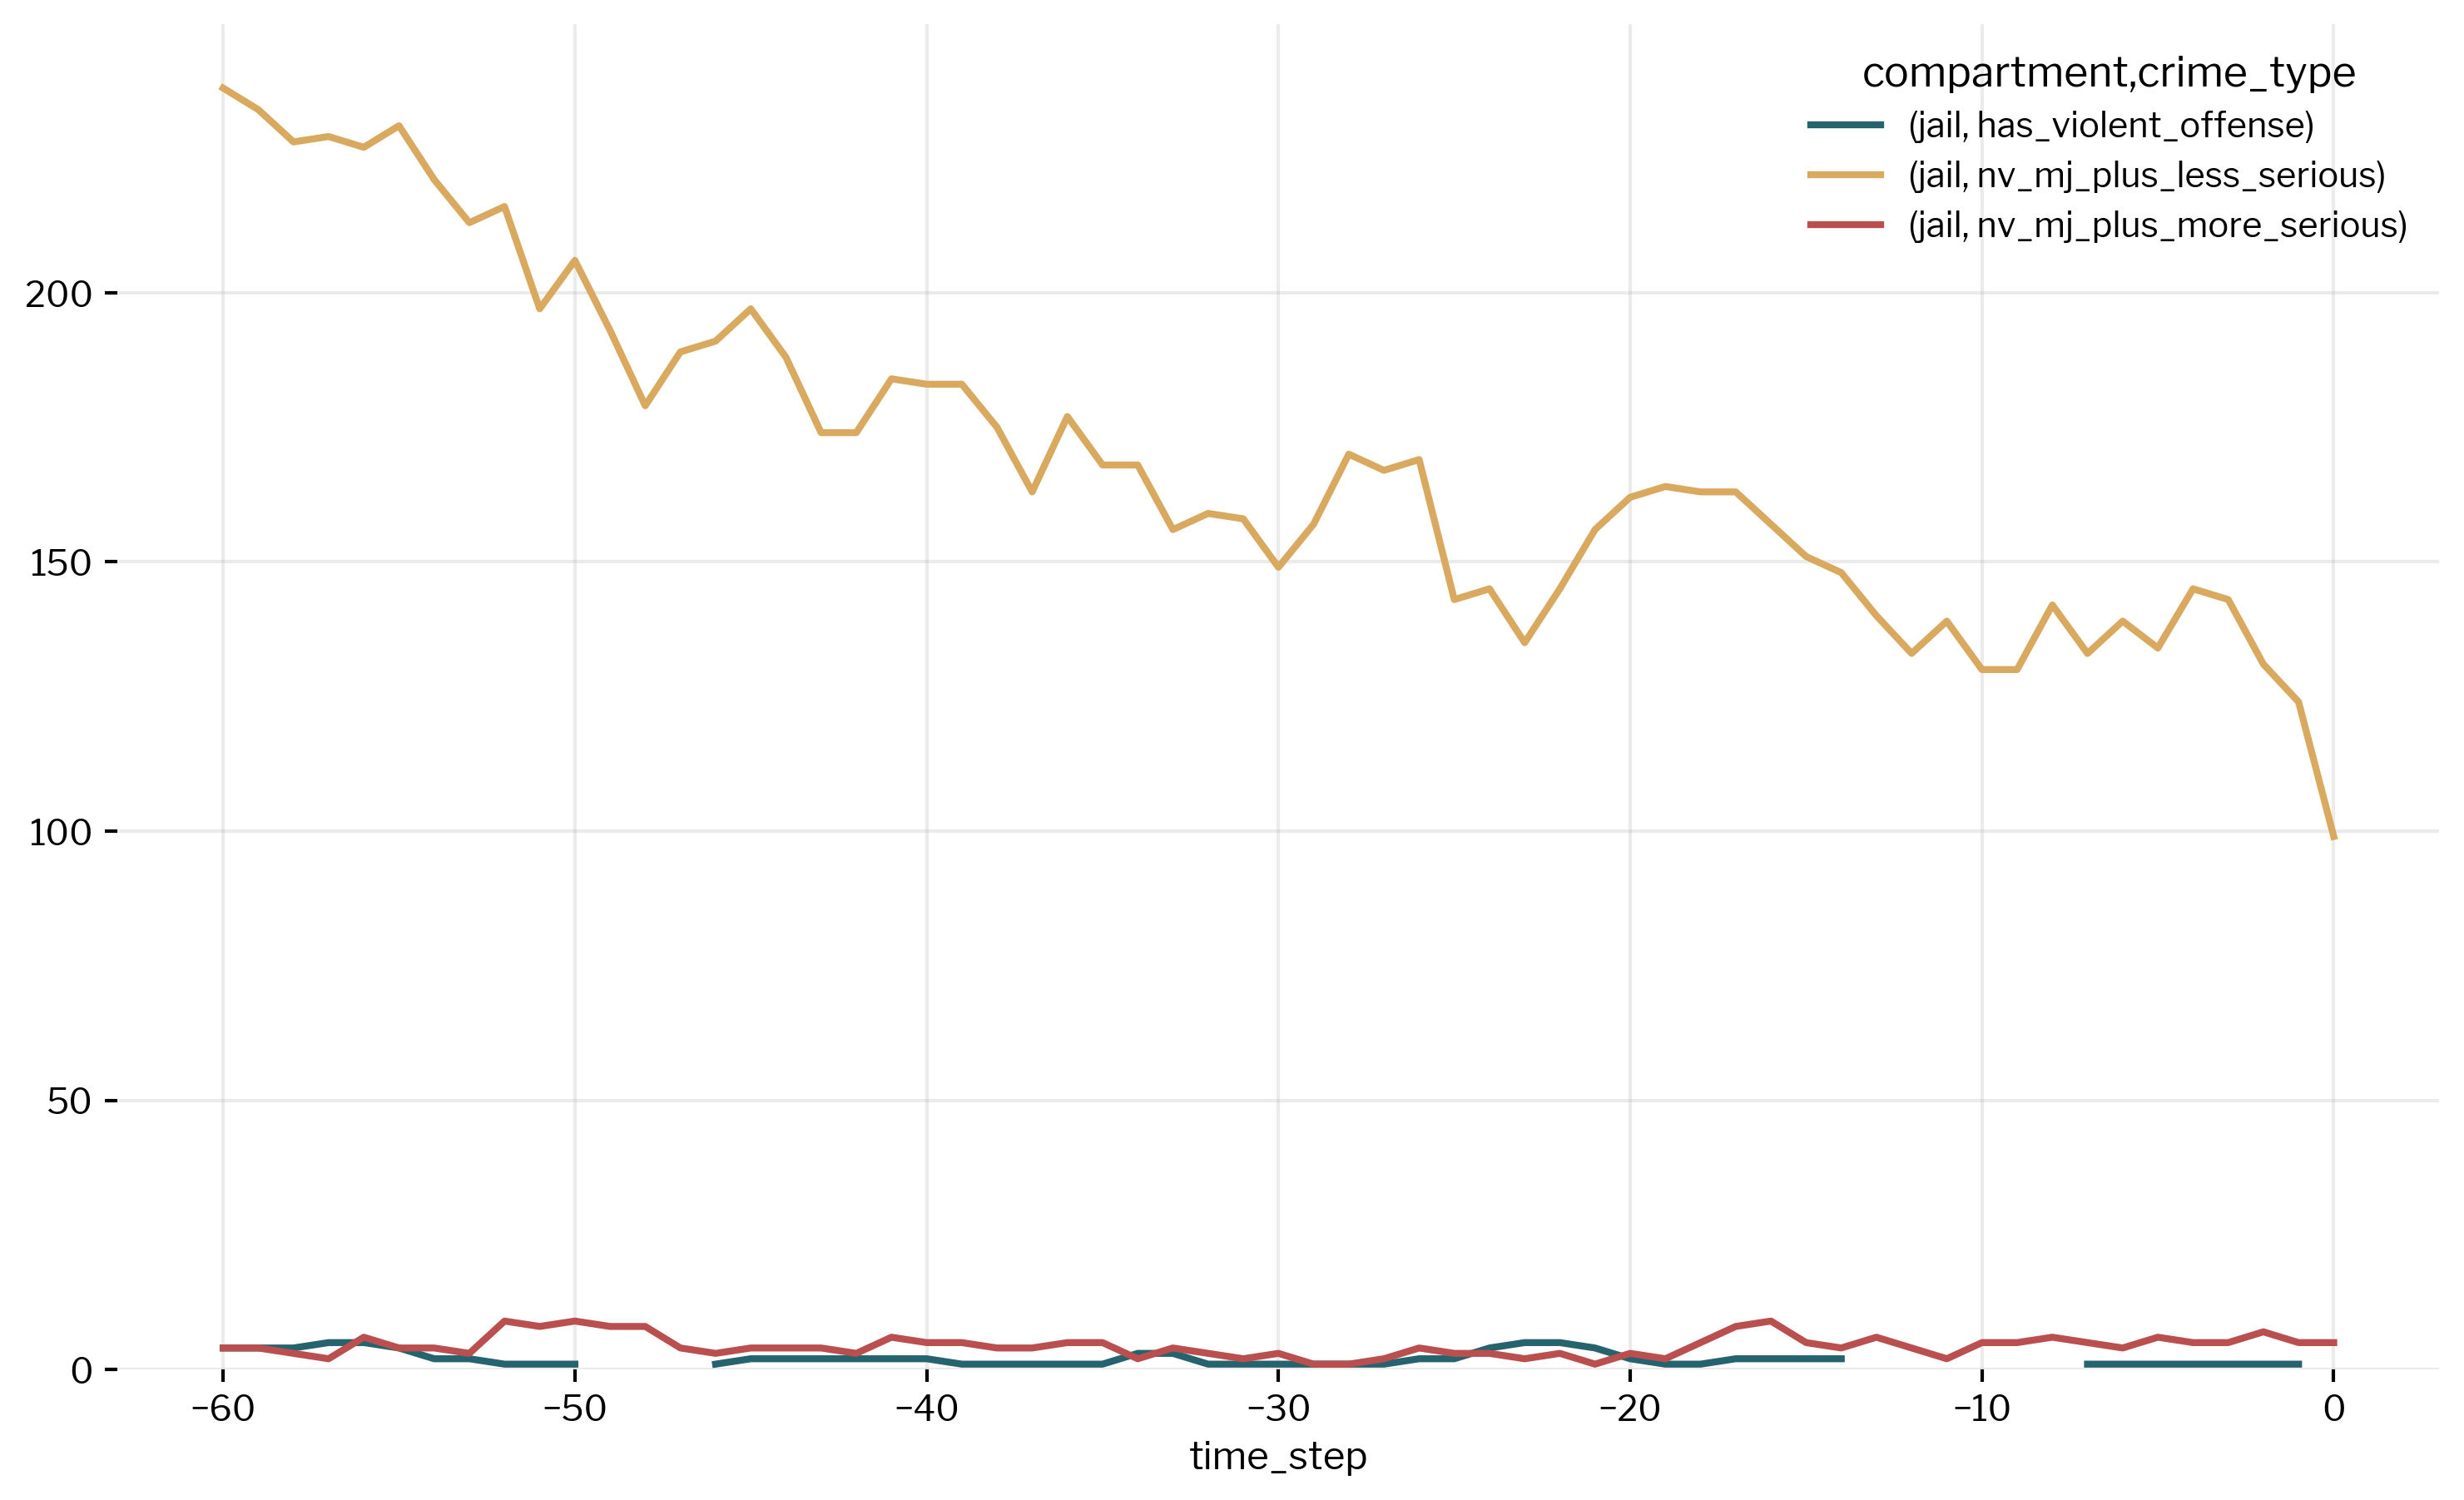

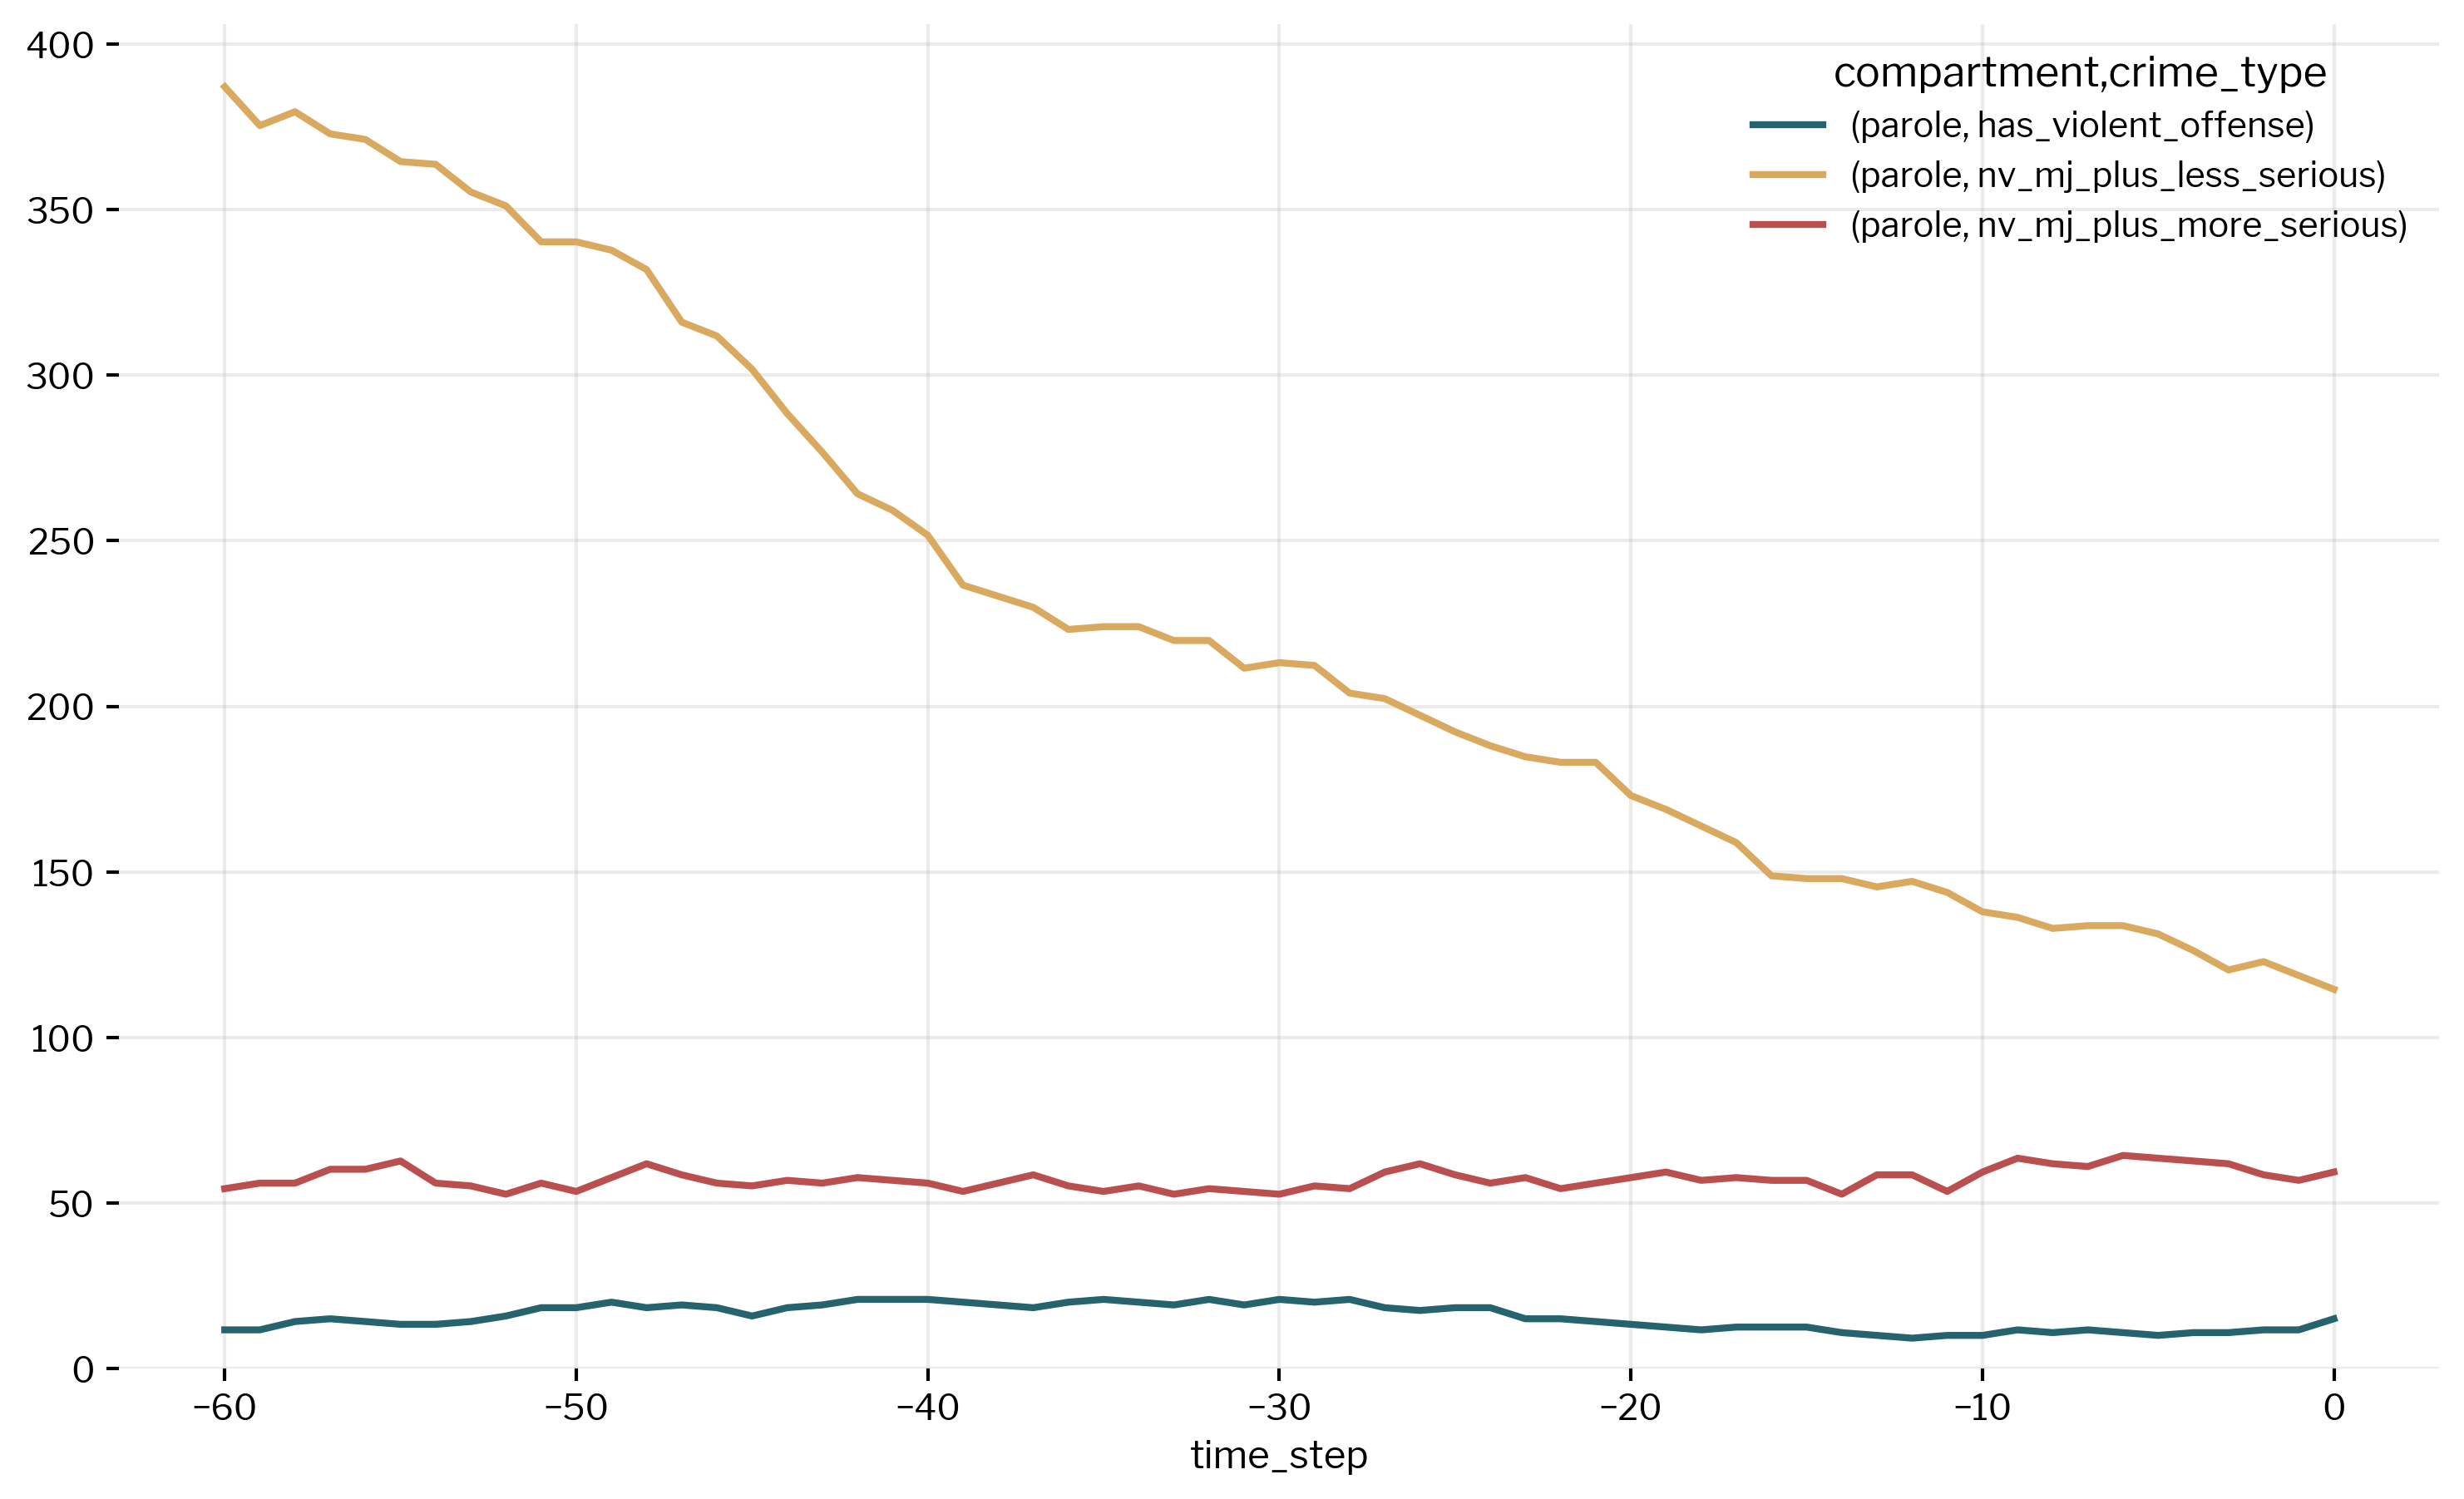

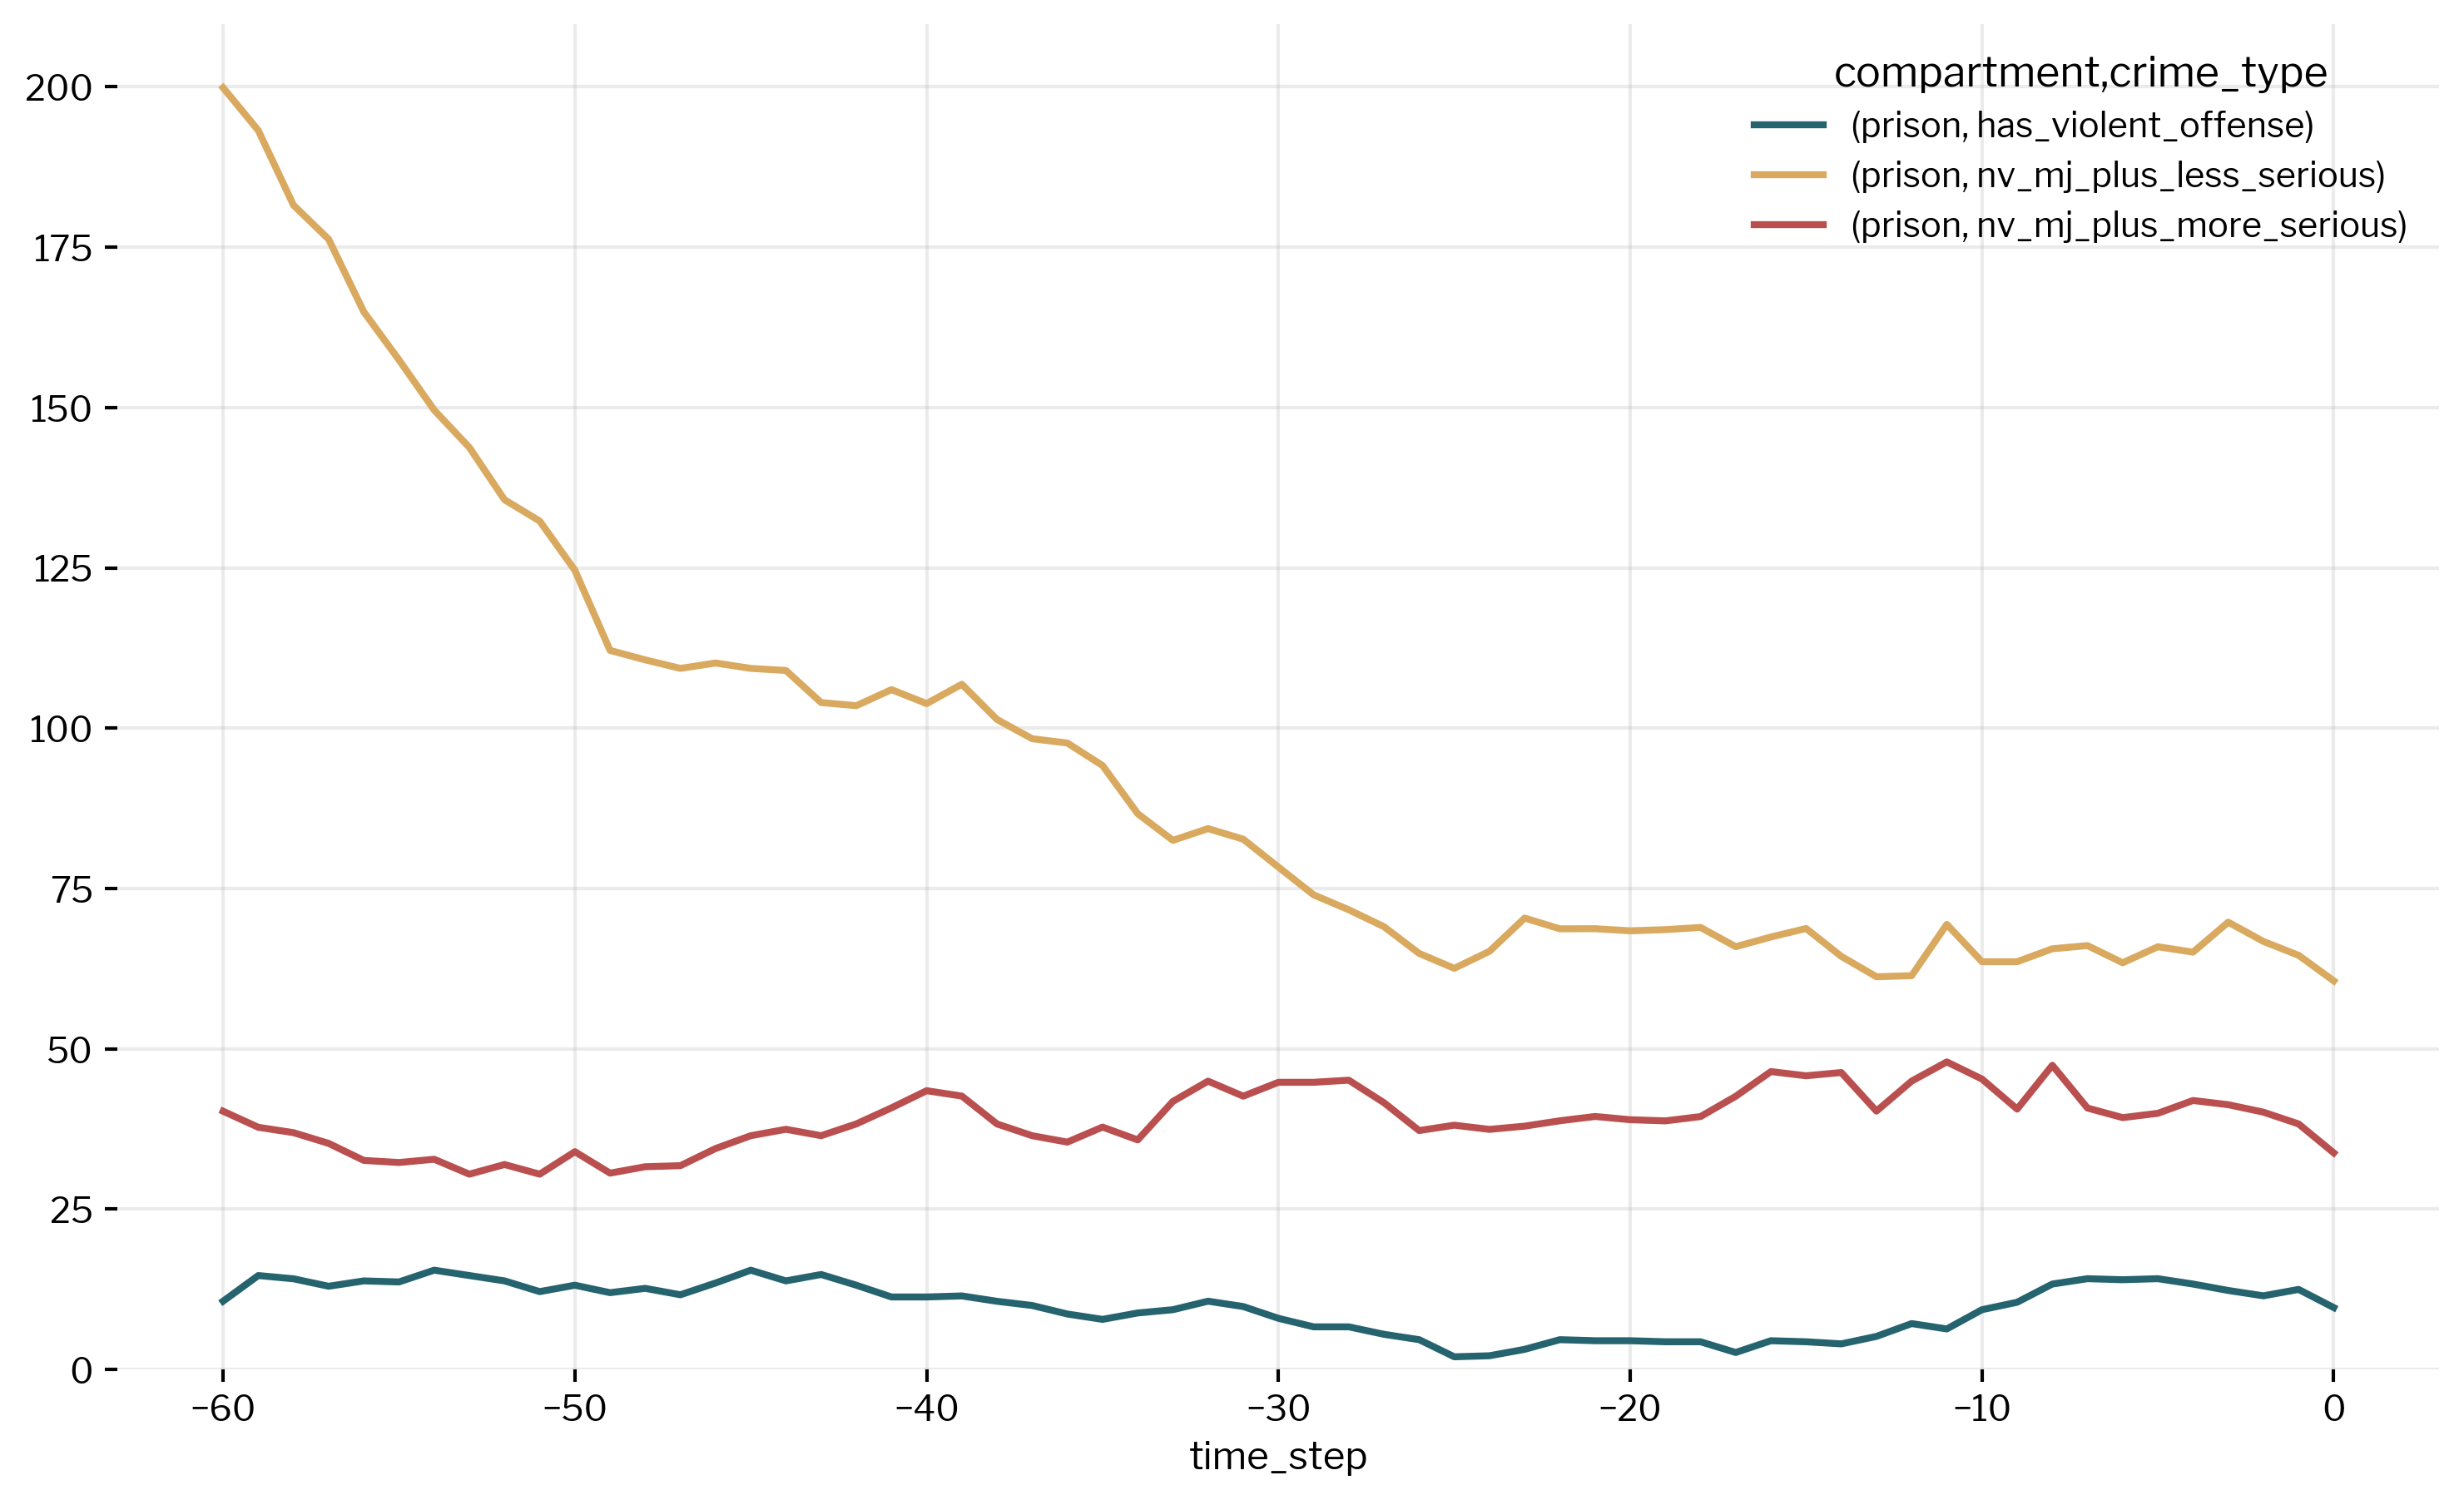

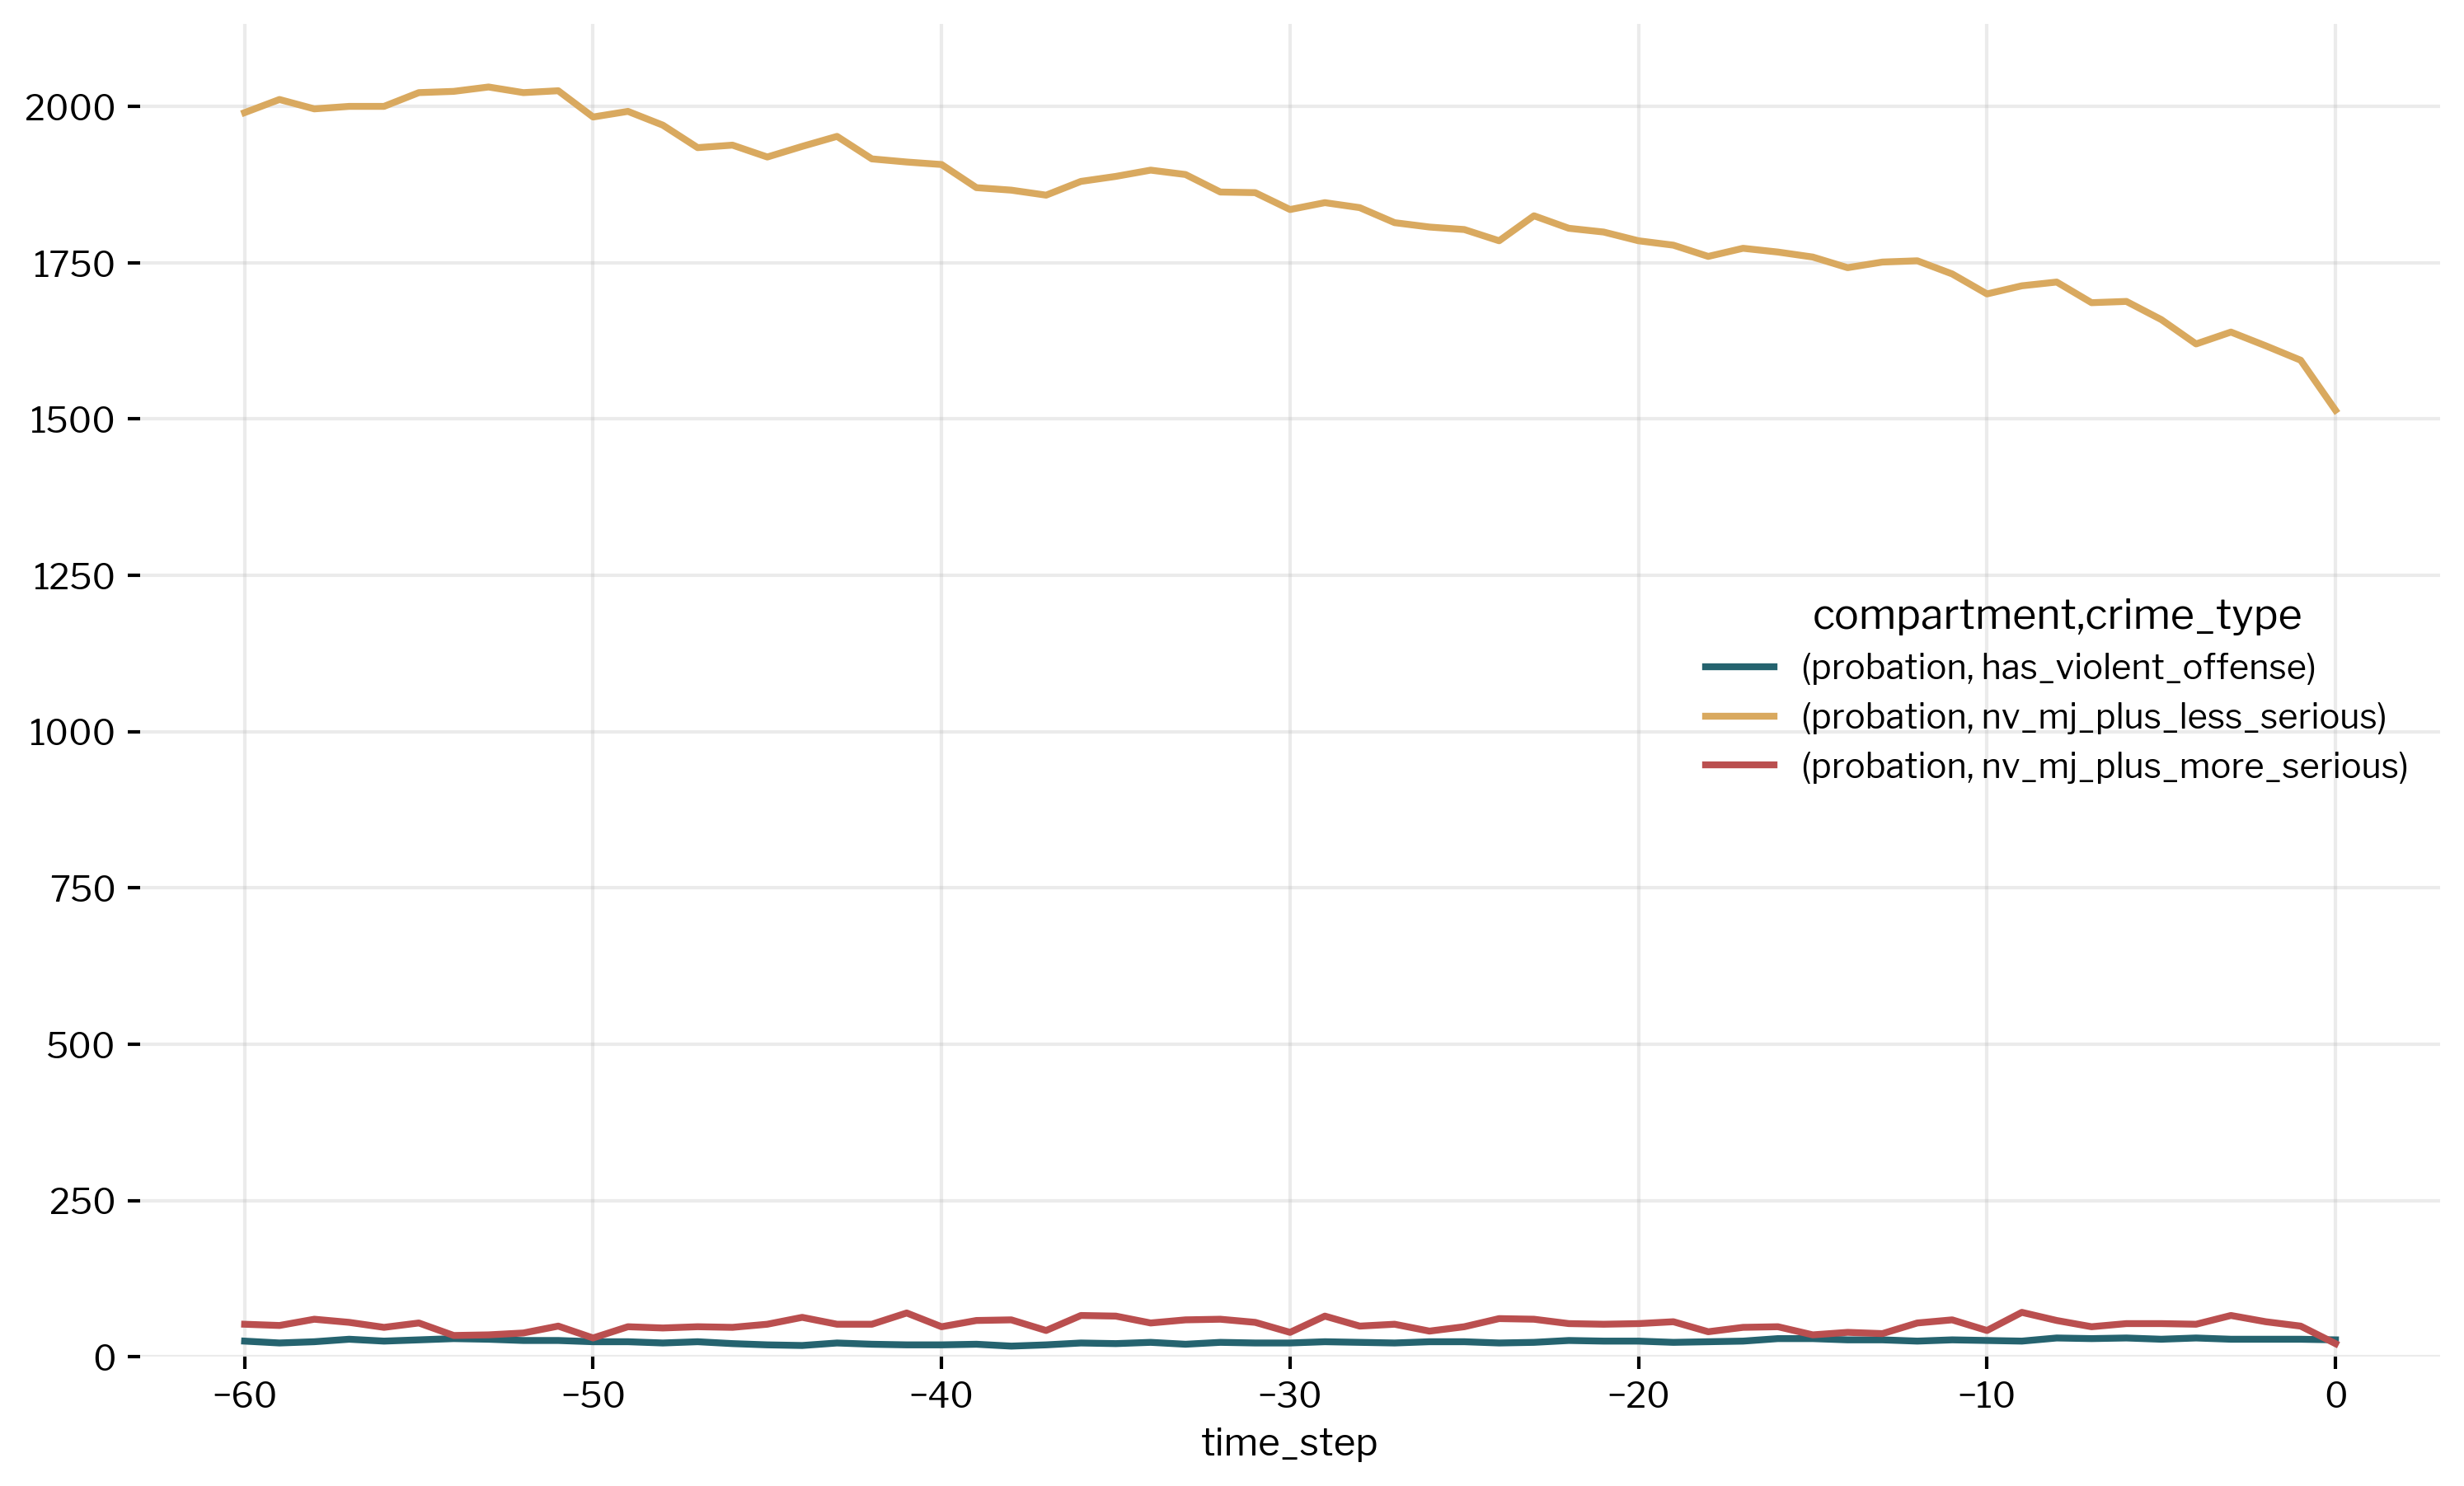

In [289]:
# disagg_for_plot = ["race", "crime"]
disagg_for_plot = ["crime_type"]
for compartment in total_population.compartment.unique():
    total_population.groupby(["time_step", "compartment"] + disagg_for_plot)[
        ["total_population"]
    ].sum().reset_index().pivot(
        index="time_step",
        columns=["compartment"] + disagg_for_plot,
        values="total_population",
    )[
        [compartment]
    ].plot()
    plt.ylim(0)

## Outflows

In [290]:
# truncate start date to month intervals
max_eligible_mj_sentences_with_month = max_eligible_mj_sentences[
    ["ID", "dos", "sentence_compartment", "start_date"] + disaggregation_axes
].copy()
max_eligible_mj_sentences_with_month[
    "month"
] = max_eligible_mj_sentences_with_month.start_date.dt.to_period("M").dt.to_timestamp()

In [292]:
# group by disagg and sentence start month
monthly_admissions_data = (
    max_eligible_mj_sentences_with_month[
        max_eligible_mj_sentences_with_month.month < "2020-01-01"
    ]
    .groupby(disaggregation_axes + ["sentence_compartment", "month"])[["ID"]]
    .nunique()
    .rename(columns={"ID": "admissions"})
)
monthly_admissions_data["compartment"] = "pretrial"
monthly_admissions_data.rename(
    columns={"sentence_compartment": "outflow_to"}, inplace=True
)

In [293]:
# # df. index get level values
# df = monthly_admissions_data.copy()
# df[(df.index.get_level_values('crime_type')=='any') & (df.index.get_level_values('sentence_compartment')=='jail')]

In [294]:
monthly_admissions_data.head()

admissions compartment
crime_type          sentence_compartment month                             
has_violent_offense jail                 2010-03-01           1    pretrial
                                         2010-04-01           3    pretrial
                                         2010-05-01           1    pretrial
                                         2010-06-01           1    pretrial
                                         2010-08-01           1    pretrial

In [ ]:
# for each crime_type [any, only] and compartment [prison, etc.]
outflows = pd.DataFrame()
for group, group_monthly_admissions in monthly_admissions_data.groupby(
    disaggregation_axes + ["sentence_compartment"]
):
    race = group[0]
    crime_type = group[1]
    disagg_arrests = avg_monthly_mj_arrests[race][[crime_type]].rename(
        columns={crime_type: "avg_arrests_per_month"}
    )
    #     display(group_monthly_admissions.reset_index([0,1,2,3,4]).head())
    # merge PA mj arrest data through 2022-10-01
    admissions_with_arrests = pd.merge(
        group_monthly_admissions.reset_index([0, 1, 2, 3]),
        disagg_arrests,
        how="outer",
        left_index=True,
        right_index=True,
    )
    admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ] = admissions_with_arrests[
        disaggregation_axes + ["sentence_compartment", "compartment"]
    ].fillna(
        method="ffill"
    )
    #     display(admissions_with_arrests)
    # count up arrests and admissions for months where we have data for both
    # 2017-01-01 thru 2019-12-01
    # calculate average rate of arrest->admission rate
    admissions_and_arrests_populated = admissions_with_arrests[
        (admissions_with_arrests.index >= start_date_for_recent_arrest_data)
        & (admissions_with_arrests.index <= end_date_for_sentencing_comm_data)
    ]
    #     display(admissions_and_arrests_populated)
    admissions_with_arrests["avg_arrest_to_admission_rate"] = (
        admissions_and_arrests_populated.admissions.sum()
        / admissions_and_arrests_populated.avg_arrests_per_month.sum()
    )
    # Calculate projected prison admissions thru 2022 based on average arrest->incarceration ratio for 2017-2019
    admissions_with_arrests["calc_admissions_by_month"] = (
        admissions_with_arrests.avg_arrests_per_month
        * admissions_with_arrests.avg_arrest_to_admission_rate
    )

    # combine historical admission data pre-2020 and projected admissions 2020 onwards
    admissions_with_arrests[
        "total_population"
    ] = admissions_with_arrests.admissions.astype("float64").combine_first(
        admissions_with_arrests.calc_admissions_by_month
    )

    # add to full outflows table
    outflows = pd.concat([outflows, admissions_with_arrests])

outflows.index = convert_dates(time_converter, outflows.reset_index()["index"].dt.date)
outflows = outflows.reset_index()
outflows = outflows[
    ["index"] + disaggregation_axes + ["sentence_compartment", "total_population"]
].copy()
outflows["compartment"] = "pretrial"
outflows = outflows.rename(
    columns={"index": "time_step", "sentence_compartment": "outflow_to"}
)
outflows = outflows[outflows.time_step >= -60]
outflows.head()

In [ ]:
outflows.groupby(["time_step", "race", "outflow_to"]).sum().reset_index().pivot(
    index="time_step", columns=["race", "outflow_to"], values="total_population"
).plot()

In [ ]:
# outflows.groupby(
#     ["time_step", "most_serious_mj", "outflow_to"]
# ).sum().reset_index().pivot(
#     index="time_step",
#     columns=["most_serious_mj", "outflow_to"],
#     values="total_population",
# ).plot()

In [ ]:
outflows_subset = (
    outflows[outflows.race.isin(["White", "Black"])]
    .groupby(["time_step", "race", "crime", "compartment", "outflow_to"])
    .sum()
    .reset_index()
    .sort_values(["race", "crime", "compartment", "outflow_to", "time_step"])
)

In [ ]:
transitions.head()

In [ ]:
transitions_subset = (
    transitions[transitions.race.isin(["White", "Black"])]
    .groupby(["race", "crime", "compartment", "outflow_to", "compartment_duration"])
    .sum()
    .reset_index()
    .sort_values(["race", "crime", "compartment", "outflow_to", "compartment_duration"])
)

In [ ]:
transitions_subset[transitions_subset.compartment == "prison"]

In [ ]:
total_population_subset = (
    total_population[total_population.race.isin(["White", "Black"])]
    .groupby(["race", "crime", "compartment", "time_step"])
    .sum()
    .reset_index()
    .sort_values(["race", "crime", "compartment", "time_step"])
)

In [ ]:
upload_spark_model_inputs(
    project_id="recidiviz-staging",
    simulation_tag=simulation_tag,
    outflows_data_df=outflows_subset,
    transitions_data_df=transitions_subset,
    total_population_data_df=total_population_subset,
    yaml_path=yaml_file_path,
)

## ARREST PLOTS

In [ ]:
totals = pd.DataFrame()
for col in set(pa_mj_arrests.columns.get_level_values(0)[:-1]):
    total_col = pd.DataFrame(pa_mj_arrests[[col]].sum(axis=1))
    total_col = total_col.set_axis([col], 1)
    totals = pd.concat([totals, total_col], axis=1)
totals[["White", "Black"]].plot()

In [ ]:
totals

In [ ]:
totals["Whites"] = totals.White - totals.Hispanic

In [ ]:
totals

In [ ]:
race = totals[["White", "Black"]]
race["pop"] = 12960000
race["together"] = race.White + race.Black
race["Black_pop"] = 12960000 * 0.122
race["white_pop"] = 12960000 * 0.81
race["white_pc"] = race.White / race.white_pop
race["Black_pc"] = race.Black / race.Black_pop
race["ratio"] = race.Black_pc / race.white_pc
race[["ratio"]]
# race[['white_pc','Black_pc']].plot()

In [ ]:
race.ratio.plot.bar()
plt.ylim(0)

In [ ]:
pa_mj

In [ ]:
totals = pa_mj_arrests[["other_total", "white_total", "Black_total", "Total_total"]]
totals
percent = totals.divide(totals.Total_total, axis=0)
percent.plot()

In [ ]:
sale = pa_mj_arrests.iloc[:, pa_mj_arrests.columns.get_level_values(1) == "sale"]
percent = sale / sale.Total
percent.plot()

In [ ]:
sale = pa_mj_arrests.iloc[:, pa_mj_arrests.columns.get_level_values(1) == "poss"]
percent = sale / sale.Total
percent.plot()

## ARREST PROBLEMS

####  PADOC data has 1.2% Hispanic clients for drug offenses by race

In [ ]:
pd.read_gbq(
    """
with person_id_w_race as (
  SELECT
    sen.person_id,
    prioritized_race_or_ethnicity,
    date_imposed
  FROM `recidiviz-123.sessions.sentences_preprocessed_materialized` sen
  JOIN `recidiviz-123.sessions.compartment_sessions_materialized` ses
      ON ses.person_id = sen.person_id 
      AND ses.start_date BETWEEN sen.effective_date AND COALESCE(sen.completion_date, '9999-01-01')
  WHERE sen.state_code = 'US_PA'
      AND sen.date_imposed > DATE_SUB(CURRENT_DATE, INTERVAL 1 YEAR)
      AND offense_type = "DRUGS"
  GROUP BY 1,2,3
)
SELECT
  prioritized_race_or_ethnicity,
  count(*),
  100 * count(*) / (sum(count(*)) OVER()) as pct
FROM person_id_w_race
WHERE date_imposed > '2021-11-18'
GROUP BY 1
ORDER BY 3 desc
""",
    project_id="recidiviz-staging",
)

####  PACS data has ~.5% Hispanic clients for MJ offenses by race

In [ ]:
race_breakdown = pd.read_gbq(
    """with race_and_crime_type as (
  SELECT
    CASE 
      WHEN off_race = 'White' then 'White'
      WHEN off_race = 'Black' then 'Black'
      WHEN off_race = 'Hispanic' then 'Hispanic'
      ELSE 'Other'
    END as race,
    CASE
      WHEN CAST(ogs as int64) <= 1 then 'poss'
      ELSE 'sale'
    END as crime_type,
    DOS,
    DRUG
  FROM `recidiviz-staging.spark_public_input_data.us_pa_charge_data_2022_nov` pa
)
Select
  race,
  crime_type,
  100 * count(*) / (sum(count(*)) OVER(PARTITION BY crime_type)) as pct
  FROM race_and_crime_type
  WHERE SAFE.PARSE_DATE('%F', SPLIT(DOS,' ')[OFFSET(0)]) > '2019-01-01'
    AND REGEXP_CONTAINS(DRUG,r'(?i)marij')
  GROUP BY 1,2
  ORDER BY 2,3 desc
""",
    project_id="recidiviz-staging",
)

In [ ]:
race_breakdown

In [ ]:
all_offenses["test"] = all_offenses.ID.cumsum()
all_offenses["total"] = all_offenses.ID.sum()
all_offenses["percent_covered"] = all_offenses.test / all_offenses.total
all_offenses = all_offenses.reset_index()

In [ ]:
all_offenses["is_violent"] = False
all_offenses_top_90 = all_offenses[all_offenses.percent_covered < 0.9]